In [1]:
'''
1.データの準備
'''
import numpy as np
from sklearn.model_selection import train_test_split

# 乱数生成時のシード(種)
np.random.seed(123)

# 入力データの次元
input_dim = 2
# クラスごとのデータ数
n = 500

# 平均(3,2)の正規分布に従うデータを生成
x1 = np.random.randn(n, input_dim) + np.array([3, 2])
# 平均(7,6)の正規分布に従うデータを生成
x2 = np.random.randn(n, input_dim) + np.array([7, 6])
# x1の正解ラベル0を2階テンソルとして生成
t1 = np.array([[0] for i in range(n)])
# x2の正解ラベル1を2階テンソルとして生成
t2 = np.array([[1] for i in range(n)])

# x1、x2を行方向に連結
x = np.concatenate((x1, x2), axis=0)
# t1、t2を行方向に連結
t = np.concatenate((t1, t2), axis=0)

x = x.astype('float32') # 訓練データをfloat64からfloat32に変換
t = t.astype('float32') # 正解ラベルをfloat64からfloat32に変換

# 訓練データと検証データに8：2の割合で分割   \は行継続文字
x_train, x_validation, t_train, t_validation = \
    train_test_split(x, t, test_size=0.2)

print('x:', x.shape)
print('t:', t.shape)

x: (1000, 2)
t: (1000, 1)


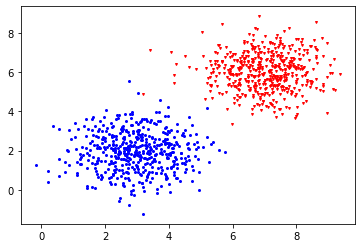

In [2]:
'''
2.データをグラフにする
'''
import matplotlib.pyplot as plt
# グラフのインライン表示
%matplotlib inline

# 正解が0のデータをプロット
plt.plot(x[:500,0], x[:500,1], 'o',  color='blue', markersize=2)
# 正解が1のデータをプロット
plt.plot(x[500:,0], x[500:,1], 'v',  color='red',markersize=2)
plt.show()

In [3]:
'''
3.モデルの定義
'''
import tensorflow as tf

class MLP(tf.keras.Model):
    '''多層パーセプトロン
    
    Attributes:
      l1(Dense): 隠れ層
      l2(Dense): 出力層
    '''
    def __init__(self, hidden_dim, output_dim):
        '''
        Parameters:
          hidden_dim(int): 隠れ層のユニット数(次元)
          output_dim(int): 出力層のユニット数(次元)
        '''
        super().__init__()
        # 隠れ層、活性化関数はシグモイド
        self.l1 = tf.keras.layers.Dense(hidden_dim, activation='sigmoid')
        # 出力層、活性化関数はシグモイド
        self.l2 = tf.keras.layers.Dense(output_dim, activation='sigmoid')

    def call(self, x):
        '''MLPのインスタンスからコールバックされる関数
        
        Parameters: x(ndarray(float32)):訓練データ、または検証データ
        Returns(float32): 出力層からの出力値        
        '''
        h = self.l1(x) # 第1層の出力
        y = self.l2(h) # 出力層の出力
        return y

In [4]:
'''
4.クロスエントロピー誤差を求める関数の定義
'''
# バイナリ用のクロスエントロピー誤差のオブジェクトを生成
bce = tf.keras.losses.BinaryCrossentropy()

def loss(t, y):
    '''損失関数
    Parameters: t(ndarray(float32)):正解ラベル
                y(ndarray(float32)):予測値
                
    Returns: クロスエントロピー誤差
    '''
    return bce(t, y)

In [5]:
'''
5.勾配降下アルゴリズムによるパラメーターの更新処理
'''
# 勾配降下アルゴリズムを使用するオプティマイザーを生成
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

def train_step(x, t):
    '''バックプロパゲーションによるパラメーター更新を行う
    
    Parameters: x(ndarray(float32)):訓練データ
                t(ndarray(float32)):正解ラベル
                
    Returns:
      ステップごとの訓練データと正解ラベルのクロスエントロピー誤差
    '''
    # 自動微分による勾配計算を記録するブロック
    with tf.GradientTape() as tape:
        # モデルに入力して順伝搬の出力値を取得
        outputs = model(x)
        # 出力値と正解ラベルの誤差
        tmp_loss = loss(t, outputs)
        
    # tapeに記録された操作を使用して誤差の勾配を計算        
    grads = tape.gradient(
        # 現在のステップの誤差
        tmp_loss,
        # バイアス、重みのリストを取得
        model.trainable_variables)
    # 勾配降下法の更新式を適用してバイアス、重みを更新
    optimizer.apply_gradients(zip(grads,
                                  model.trainable_variables))
    return tmp_loss

In [6]:
'''
6.モデルを使用して学習する
'''
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# 訓練データと検証データに8：2の割合で分割
x_train, x_validation, t_train, t_validation = \
    train_test_split(x, t, test_size=0.2)

# エポック数
epochs = 50                           
# ミニバッチのサイズ
batch_size = 32
#ステップ数
steps = x_train.shape[0] // batch_size

# 隠れ層2ユニット、出力層1ユニットのモデルを構築
model = MLP(2, 1)

# 学習を行う
for epoch in range(epochs):
    # 1エポックごとの損失を保持する変数
    epoch_loss = 0.
    # 訓練データと正解ラベルをシャッフル
    x_, t_ = shuffle(x_train, t_train, random_state=0)
    
    # 1ステップにおけるミニバッチを使用した学習
    for step in range(steps):
        start = steps * step     # ミニバッチの先頭インデックス
        end = start + batch_size # ミニバッチの末尾のインデックス
        # ミニバッチでバイアス、重みを更新して誤差を取得
        tmp_loss = train_step(x_[start:end], t_[start:end])
        
    # 1ステップ終了時の誤差を取得
    epoch_loss = tmp_loss.numpy()

    # 10エポックごとに結果を出力
    if (epoch + 1) % 10 == 0:
        print('epoch({}) loss: {:.3}'.format(
        epoch+1,
        epoch_loss
    ))

# モデルの概要を出力
model.summary()

epoch(10) loss: 0.528
epoch(20) loss: 0.354
epoch(30) loss: 0.196
epoch(40) loss: 0.119
epoch(50) loss: 0.0814
Model: "mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  6         
_________________________________________________________________
dense_1 (Dense)              multiple                  3         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


In [10]:
'''
7．モデルの評価
'''
# 検証データの予測値を取得
t_preds = model(x_validation)
# バイナリデータの精度を取得するオブジェクトを生成(閾値はデフォルトの0.5)
bn_acc = tf.keras.metrics.BinaryAccuracy(threshold=0.5)
# 精度を測定するデータを設定
bn_acc.update_state(t_validation, t_preds)
# 検証データの精度を取得
validation_acc = bn_acc.result().numpy()
# 検証データの損失を取得
validation_loss = loss(t_validation, t_preds)
# 損失と精度を出力
print(
    'val_loss: {:.4f}\nval_acc : {:.4f}'.format(validation_loss,
                                               validation_acc))

val_loss: 0.0807
val_acc : 1.0000
